## Importing Libraries and Loading Our Data

In [1]:
# Importing necessay packages
import sys
import findspark
findspark.init()
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import format_string
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import col, avg
from pyspark.sql import functions as F
                             
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.classification import SVMWithSGD

from pyspark.sql import DataFrame
!HADOOP_LIBPATH='/opt/cloudera/parcels/CDH/lib'
!HADOOP_STREAMING='hadoop-mapreduce/hadoop-streaming.jar'

!alias hfs="$HADOOP_EXE fs"

sc = SparkContext()
spark = SparkSession(sc)


%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

In [ ]:
# Unzipping the Dataset zip file

!unzip './the-movies-dataset.zip'

Archive:  ./the-movies-dataset.zip
replace credits.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Moving the data files to HDFS

!hadoop fs -put credits.csv
!hadoop fs -put keywords.csv
!hadoop fs -put links.csv
!hadoop fs -put links_small.csv
!hadoop fs -put movies_metadata.csv
!hadoop fs -put ratings.csv
!hadoop fs -put ratings_small.csv

In [2]:
# Reading Movies Metadata file to a spark dataframe

df_movies_metadata = spark.read.format("csv").option("header","true").load("movies_metadata.csv")
df_movies_metadata.head()

Row(adult='False', belongs_to_collection="{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}", budget='30000000', genres="[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]", homepage='http://toystory.disney.com/toy-story', id='862', imdb_id='tt0114709', original_language='en', original_title='Toy Story', overview="Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.", popularity='21.946943', poster_path='/rhIRbceoE9lR4veEXuwCC2wARtG.jpg', production_companies="[{'name': 'Pixar Animation Studios', 'id': 3}]", production_countries="[{'iso_3166_1': 'US', 'name': 'United States of America'}]", releas

In [3]:
# Columns of Movies-Metadata

df_movies_metadata.columns

['adult',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'id',
 'imdb_id',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count']

In [4]:
# Number of Entries in Movies-meta data

print("Number of Entries in Meta data dataframe:",df_movies_metadata.count())

Number of Entries in Meta data dataframe: 45572


In [5]:
# Column datatypes of movies_metadata dataframe

df_movies_metadata.describe()

DataFrame[summary: string, adult: string, belongs_to_collection: string, budget: string, genres: string, homepage: string, id: string, imdb_id: string, original_language: string, original_title: string, overview: string, popularity: string, poster_path: string, production_companies: string, production_countries: string, release_date: string, revenue: string, runtime: string, spoken_languages: string, status: string, tagline: string, title: string, video: string, vote_average: string, vote_count: string]

In [6]:
# Data Cleaning

# Dropping Unnecessary columns (imdb_id)

df_movies_metadata = df_movies_metadata.drop("imdb_id")

# Removing original_title and retaining the translated title

df_movies_metadata.select(["original_title","title"]).show(10)

df_movies_metadata = df_movies_metadata.drop("original_title")

+--------------------+--------------------+
|      original_title|               title|
+--------------------+--------------------+
|           Toy Story|           Toy Story|
|             Jumanji|             Jumanji|
|    Grumpier Old Men|    Grumpier Old Men|
|   Waiting to Exhale|[{'iso_639_1': 'e...|
|Father of the Bri...|Father of the Bri...|
|                Heat|                Heat|
|             Sabrina|             Sabrina|
|        Tom and Huck|        Tom and Huck|
|        Sudden Death|        Sudden Death|
|           GoldenEye|           GoldenEye|
+--------------------+--------------------+
only showing top 10 rows



In [7]:
# Presence of Zero-revenue movies
print("Before replacing Zero values")
df_movies_metadata.select("revenue","budget").show()

print("Number of Movie records with Revenue as 0")
print(df_movies_metadata.filter(df_movies_metadata.revenue=='0').count())

print("After replacing Zero values")
df_movies_metadata = df_movies_metadata.withColumn("revenue", df_movies_metadata["revenue"].cast(IntegerType()))
df_movies_metadata = df_movies_metadata.withColumn("revenue", F.when(F.col("revenue").isNull(), np.nan).otherwise(F.col("revenue")))
df_movies_metadata = df_movies_metadata.withColumn("revenue", F.when(F.col("revenue")=='0', np.nan).otherwise(F.col("revenue")))
df_movies_metadata.select(["revenue","budget"]).show()

Before replacing Zero values
+--------------------+--------+
|             revenue|  budget|
+--------------------+--------+
|           373554033|30000000|
|           262797249|65000000|
|                   0|       0|
|[{'name': 'Twenti...|16000000|
|            76578911|       0|
|           187436818|60000000|
|                   0|58000000|
|                   0|       0|
|            64350171|35000000|
|           352194034|58000000|
|           107879496|62000000|
|                   0|       0|
|            11348324|       0|
|            13681765|44000000|
|            10017322|98000000|
|           116112375|52000000|
|           135000000|16500000|
|             4300000| 4000000|
|           212385533|30000000|
|            35431113|60000000|
+--------------------+--------+
only showing top 20 rows

Number of Movie records with Revenue as 0
34799
After replacing Zero values
+------------+--------+
|     revenue|  budget|
+------------+--------+
|3.73554033E8|30000000|
|2.62

In [8]:
# Casting Budget to IntegerType and replacing zero budget entries to NaN

df_movies_metadata = df_movies_metadata.withColumn("budget", df_movies_metadata["budget"].cast(IntegerType()))
df_movies_metadata = df_movies_metadata.withColumn("budget", F.when(F.col("budget")==0, np.nan).otherwise(F.col("budget")))
df_movies_metadata.select("budget").show()

+---------+
|   budget|
+---------+
|    3.0E7|
|    6.5E7|
|      NaN|
|    1.6E7|
|      NaN|
|    6.0E7|
|    5.8E7|
|      NaN|
|    3.5E7|
|    5.8E7|
|    6.2E7|
|      NaN|
|      NaN|
|    4.4E7|
|    9.8E7|
|    5.2E7|
|   1.65E7|
|4000000.0|
|    3.0E7|
|    6.0E7|
+---------+
only showing top 20 rows



In [9]:
# Creating a New column called Return : (Revenue/Budget) to assess the success of movies

df_movies_metadata = df_movies_metadata.withColumn("return",df_movies_metadata["revenue"]/df_movies_metadata["budget"])
df_movies_metadata.select(["revenue","budget","return"]).show()

+------------+---------+-------------------+
|     revenue|   budget|             return|
+------------+---------+-------------------+
|3.73554033E8|    3.0E7|         12.4518011|
|2.62797249E8|    6.5E7|          4.0430346|
|         NaN|      NaN|                NaN|
|         NaN|    1.6E7|                NaN|
| 7.6578911E7|      NaN|                NaN|
|1.87436818E8|    6.0E7|  3.123946966666667|
|         NaN|    5.8E7|                NaN|
|         NaN|      NaN|                NaN|
| 6.4350171E7|    3.5E7| 1.8385763142857143|
|3.52194034E8|    5.8E7|  6.072310931034483|
|1.07879496E8|    6.2E7|  1.739991870967742|
|         NaN|      NaN|                NaN|
| 1.1348324E7|      NaN|                NaN|
| 1.3681765E7|    4.4E7|0.31094920454545455|
| 1.0017322E7|    9.8E7|0.10221757142857144|
|1.16112375E8|    5.2E7| 2.2329302884615383|
|      1.35E8|   1.65E7|  8.181818181818182|
|   4300000.0|4000000.0|              1.075|
|2.12385533E8|    3.0E7|  7.079517766666667|
| 3.543111

In [10]:
# Extracting and creating a year column from release date of movie 
df_movies_metadata = df_movies_metadata.withColumn("year", year(df_movies_metadata["release_date"]).alias('year'))

In [11]:
# Dropping Adult column as very few movies qualify as Adult

print("Number of Adult Movies:",df_movies_metadata.filter(df_movies_metadata["adult"]==True).select("adult").count())
print("Therefore,we can safely remove that column")
df_movies_metadata = df_movies_metadata.drop("adult")


Number of Adult Movies: 9
Therefore,we can safely remove that column


In [ ]:
df = df_movies_metadata

In [18]:
df['popularity'] = df['popularity'].astype('float')
df['vote_count'] = df['vote_count'].astype('float')
df['vote_average'] = df['vote_average'].astype'float')

In [19]:
df['popularity'].describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

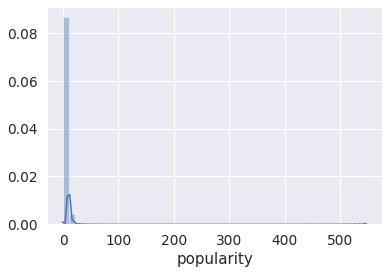

In [20]:
sns.distplot(df['popularity'].fillna(df['popularity'].median()))
plt.show()

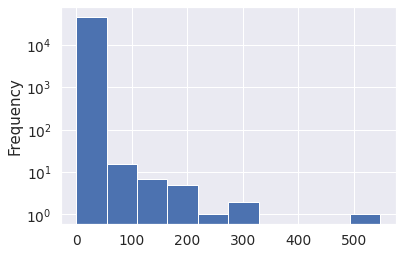

In [21]:
df['popularity'].plot(logy=True, kind='hist')

In [22]:
df[['title', 'popularity', 'year']].sort_values('popularity', ascending=False).head(10)

,title,popularity,year
30700,Minions,547.488298,2015
33356,Wonder Woman,294.337037,2017
42222,Beauty and the Beast,287.253654,2017
43644,Baby Driver,228.032744,2017
24455,Big Hero 6,213.849907,2014
26564,Deadpool,187.860492,2016
26566,Guardians of the Galaxy Vol. 2,185.330992,2017
14551,Avatar,185.070892,2009
24351,John Wick,183.870374,2014
23675,Gone Girl,154.801009,2014


**Minions** is the most popular movie by the TMDB Popularity Score. **Wonder Woman** and **Beauty and the Beast**, two extremely successful woman centric movies come in second and third respectively.

In [23]:
df['vote_count'].describe()

count    45460.000000
mean       109.897338
std        491.310374
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

As with popularity scores, the distribution of vote counts is extremely skewed with the median vote count standing at a paltry 10 votes. The most votes a single movie has got stands at 14,075. TMDB Votes, therefore, are not as potent and suggestive as its IMDB Counterpart. Nevertheless, let us check which the most voted on movies on the website are.

#### Most Voted on Movies

In [25]:
df[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(10)

,title,vote_count,year
15480,Inception,14075.0,2010
12481,The Dark Knight,12269.0,2008
14551,Avatar,12114.0,2009
17818,The Avengers,12000.0,2012
26564,Deadpool,11444.0,2016
22879,Interstellar,11187.0,2014
20051,Django Unchained,10297.0,2012
23753,Guardians of the Galaxy,10014.0,2014
2843,Fight Club,9678.0,1999
18244,The Hunger Games,9634.0,2012


**Inception** and **The Dark Knight**, two critically acclaimed and commercially successful Christopher Nolan movies figure at the top of our chart.

In [26]:
df['vote_average'] = df['vote_average'].replace(0, np.nan)
df['vote_average'].describe()

count    42462.000000
mean         6.014877
std          1.256208
min          0.500000
25%          5.300000
50%          6.100000
75%          6.900000
max         10.000000
Name: vote_average, dtype: float64

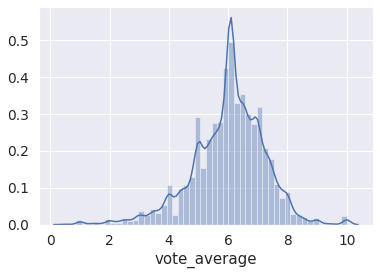

In [27]:
sns.distplot(df['vote_average'].fillna(df['vote_average'].median()))

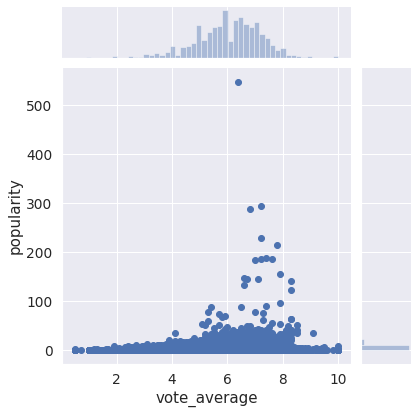

In [29]:
sns.jointplot(x='vote_average', y='popularity', data=df)

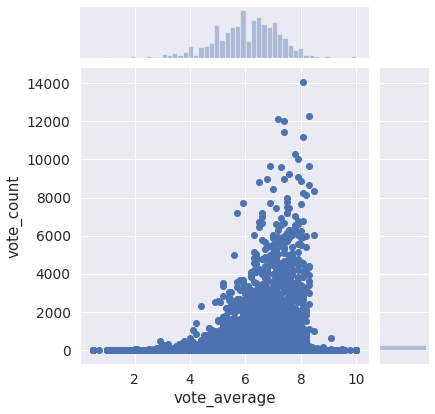

In [30]:
sns.jointplot(x='vote_average', y='vote_count', data=df)

### Movie Release Dates

In [31]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [32]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [33]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [34]:
df['day'] = df['release_date'].apply(get_day)
df['month'] = df['release_date'].apply(get_month)

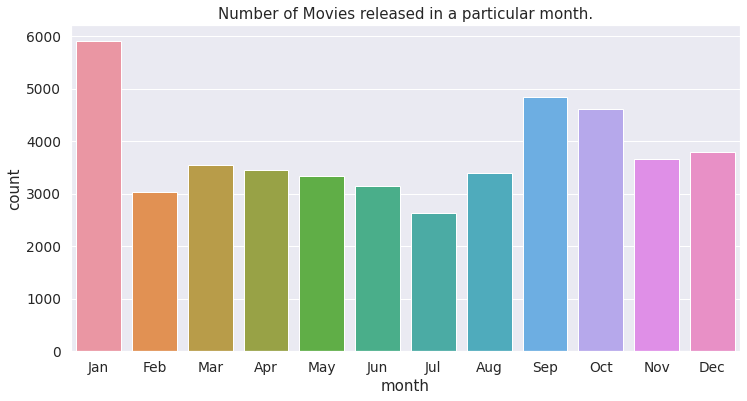

In [35]:
plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular month.")
sns.countplot(x='month', data=df, order=month_order)

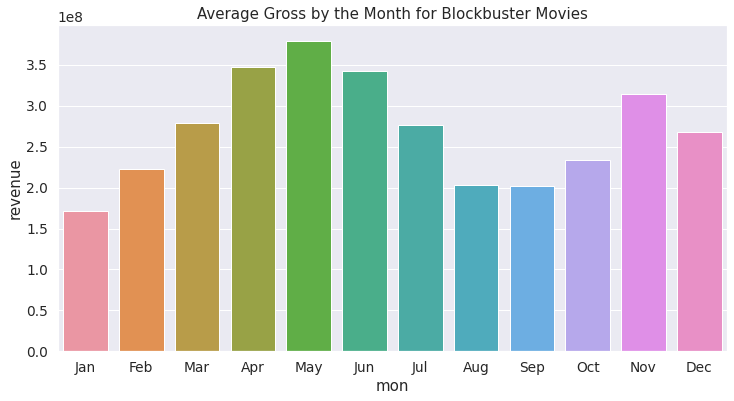

In [36]:
month_mean = pd.DataFrame(df[df['revenue'] > 1e8].groupby('month')['revenue'].mean())
month_mean['mon'] = month_mean.index
plt.figure(figsize=(12,6))
plt.title("Average Gross by the Month for Blockbuster Movies")
sns.barplot(x='mon', y='revenue', data=month_mean, order=month_order)

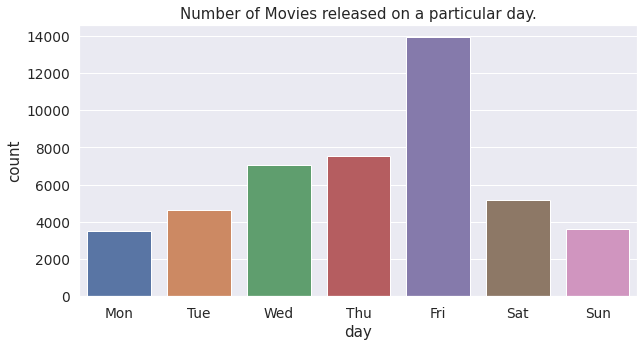

In [38]:
plt.figure(figsize=(10,5))
plt.title("Number of Movies released on a particular day.")
sns.countplot(x='day', data=df, order=day_order)

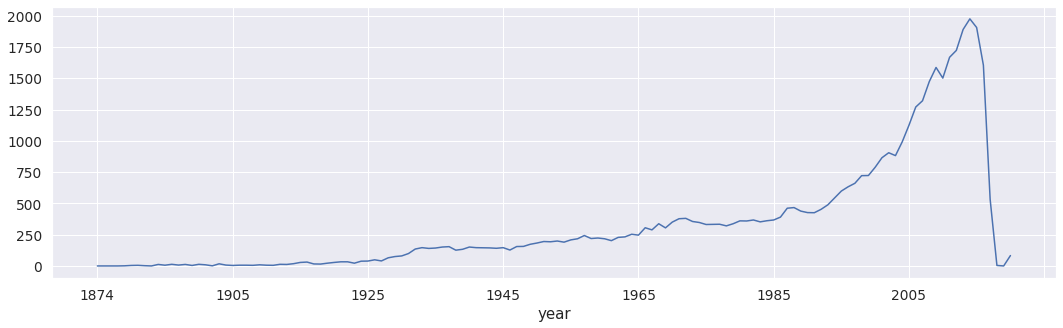

In [39]:
year_count = df.groupby('year')['title'].count()
plt.figure(figsize=(18,5))
year_count.plot()